<a href="https://colab.research.google.com/github/stephaneckstein/intro_robustpricing_ot/blob/main/intro_model_free_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to model-free finance approaches related to optimal transport

This notebook gives a short introduction to an approach of robust pricing related to optimal transport.

The idea behind robust pricing is to precisely control which assumptions are made related to market dynamics. By being conservative with the assumptions, the provided insights on the price dynamics are usually very robust. This comes at a cost though: While usual models for a stock market (like the Black Scholes or Heston model) yield precise values for prices, robust pricing methods only provide upper and lower bounds for possible prices (and those bounds can be quite far apart).

For an introduction to robust pricing (or relatedly, model uncertainty for finance), see for instance [Cont (2006)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9965.2006.00281.x?casa_token=UBX34Iaj7GEAAAAA%3AP_7YWWJhU4U_GmZ9x6O_uHR7vCl0xCdaYZdf1FmgBNCCN2OvzFDaflvZIi-sTXIo39DE9fJ1izR7pK8). More references related to the concrete robust pricing approach with optimal transport are given below.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import linprog
from scipy.special import logsumexp

## Risk-neutral marginal distributions and possible joint distributions

For many stocks nowadays, vanilla options (European call and put options) are quite liquid for many expiration dates. These vanilla options practically provide good estimates for the risk-neutral market distributions of the stock for the time points given by the expiration dates. The modelling freedom for stock models thus mostly lies at the level of the joint distributions of the stock prices across time (or, of course, on the level of dependence between different stocks; in this notebook we will only look at a single stock though).

In the following, we thus assume that we are given risk-neutral marginal distributions inferred from option prices for a stock at two future time points (e.g., [Breeden and Litzenberger (1978)](https://www.jstor.org/stable/pdf/2352653.pdf) or [Jackwerth and Rubinstein (1996)](https://onlinelibrary.wiley.com/doi/pdf/10.1111/j.1540-6261.1996.tb05219.x)). The possible joint distributions can, of course, vary widely...

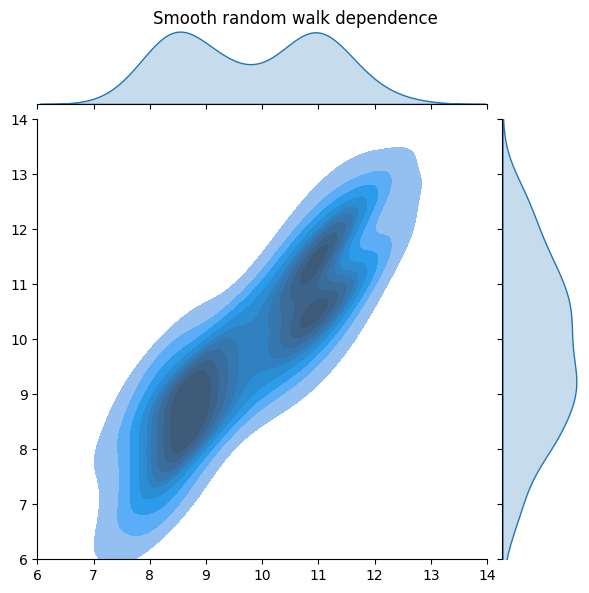

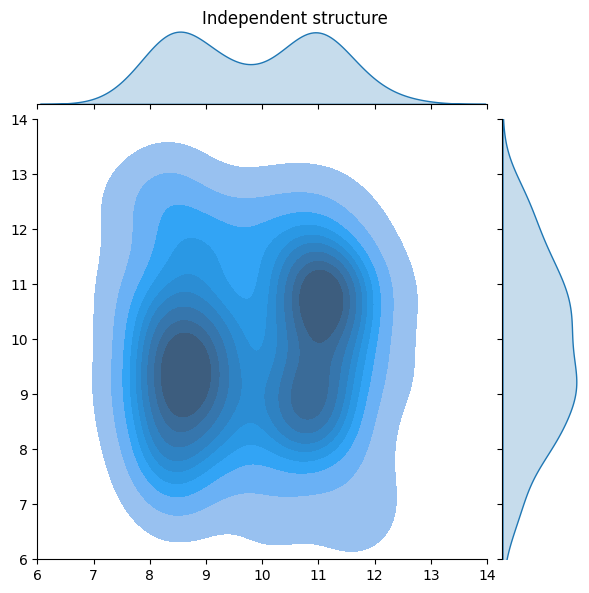

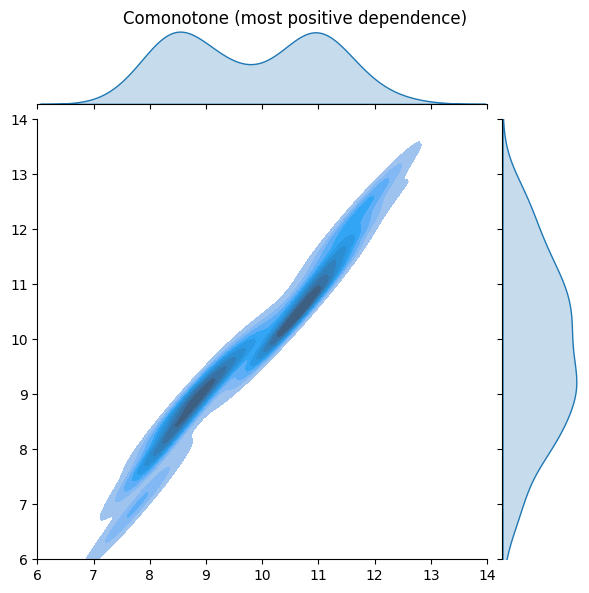

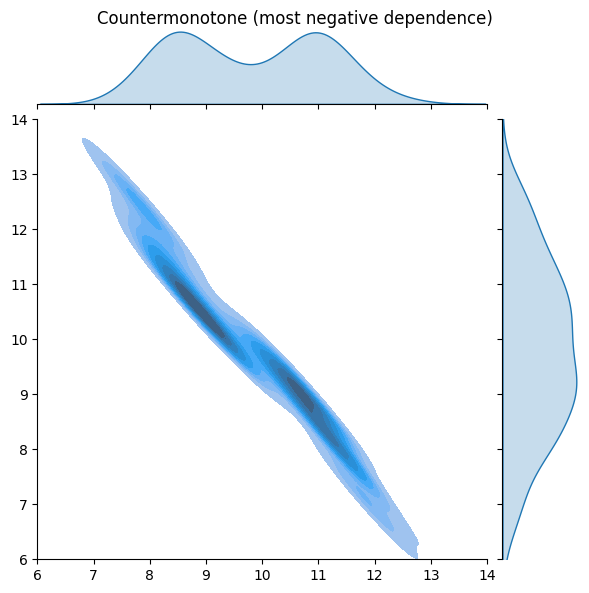

In [2]:
# defining marginals as simple mixtures of normal distributions (generated to be in convex order)
def sample_mu(K, mean1=-1.3, mean2=0.8, sig1=0.5, sig2=0.7, sig3=1.25, sig4=1.45, mixt=0.5):
    kh = int(np.ceil(K/2))
    points1 = norm.ppf(np.linspace(1/(2*kh), 1-(1/(2*kh)), kh))
    id = np.random.binomial(1, mixt, size=kh)
    points1 = points1 * (id * sig1 + (1-id) * sig2) + id * mean1 + (1-id) * mean2
    points1 = np.hstack([points1, points1])
    er2 = np.random.randn(kh)
    er2 = np.hstack([er2, -er2])
    id = np.hstack([id, id])
    points2 = points1 + er2 * ((sig3 - sig1) * id + (sig4 - sig2) * (1-id))
    return 10+points1, 10+points2


# visualizing different dependence structures
np.random.seed(0)
xm, ym = sample_mu(200)
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14],
                  marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.fig.suptitle("Smooth random walk dependence")
g.fig.subplots_adjust(top=0.95)
plt.show()
np.random.shuffle(ym)
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14],
                  marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.fig.suptitle("Independent structure")
g.fig.subplots_adjust(top=0.95)
plt.show()
xm = np.sort(xm)
ym = np.sort(ym)
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14],
                  marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.fig.suptitle("Comonotone (most positive dependence)")
g.fig.subplots_adjust(top=0.95)
plt.show()
ym = np.flip(ym)
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14],
                  marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.fig.suptitle("Countermonotone (most negative dependence)")
g.fig.subplots_adjust(top=0.95)
plt.show()




## Classical Optimal Transport for Robust Pricing

Idea of model free pricing: Without specifying a concrete model, we only make particular assumptions on our class of models and take the most extreme cases to get bounds for possible range of prices. If we do not assume any more knowledge other than marginal distributions, this leads to classical optimal transport problems.

Concretely, if we want to price a certain derivative depending on the stock value at both time points, then obtaining the supremum over possible prices only assuming knowledge of the marginal distributions is precisely an optimal transport problem, where the cost function is determined by the payoff structure of the

LP successful: True
Upper bound for possible price range:0.9268285901844056


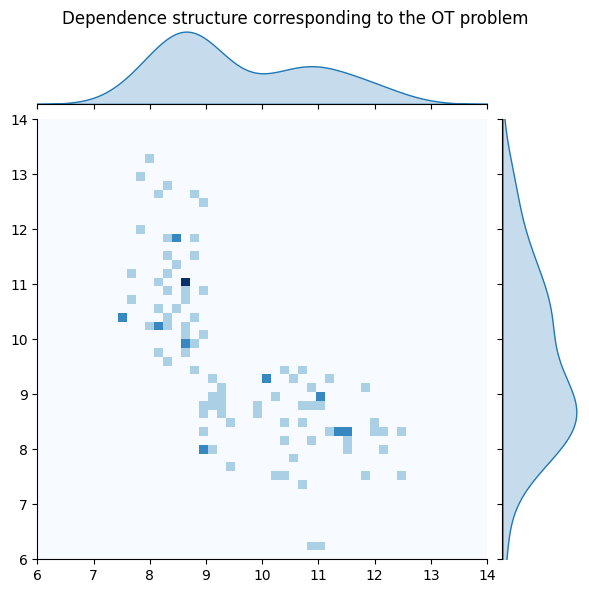

In [14]:
# Defining different cost functions
# (cost functions should rather be called payoff functions?)

# a forward start option (or is this a spread option? Not sure on the terminology...)
def cost_1(x1, x2, k_shift=0.5):
    return np.maximum((x2-x1-k_shift), 0)


# asian option
def cost_2(x1, x2, k=10):
    return np.maximum((x1+x2)/2 - k, 0)


# spread option (or something else?...)
def cost_3(x1, x2, shift=0):
    return (x1-x2-shift)**2


# Sampling marginals
n = 100
np.random.seed(0)
xm, ym = sample_mu(n)

# Set cost function, sign to maximize/minimize and one of
# cost_1, cost_2 or cost_3 (also: different strikes/shifts or new costs)
cost_vec = -cost_1(np.reshape(xm, [-1, 1]), np.reshape(ym, [1, -1])).reshape((-1, 1), order='F')

# Use scipy linprog for solving OT,
# See also https://python.quantecon.org/opt_transport.html
#
# The only obstacle is that the joint distribution needs to be represented
# as a vector, which leads to some indexing difficulties. Otherwise, normal LP:
# Objective: sum(cost_vec * pi)
# Constraints:
# We set \sum_j \pi_{i, j} = \mu_1(x_i) = 1/n for all i, (encoded by A1)
# and \sum_i \pi_{i, j} = \mu_2(x_j) = 1/n for all j. (encoded by A2)

A1 = np.kron(np.ones((1, n)), np.identity(n))  # first marginal constraint
A2 = np.kron(np.identity(n), np.ones((1, n)))  # second marginal constraint
A = np.vstack([A1, A2])
b = np.ones(2*n)/n  # marginals are empirical measures, thus all masses are 1/n
res = linprog(cost_vec, A_eq=A, b_eq=b)

print('LP successful: ' + str(res.success))
if np.sum(res.x*cost_vec.flatten()) > 0:
  print('Lower bound for possible price range:' + str(np.sum(res.x*cost_vec.flatten())))
else:
  print('Upper bound for possible price range:' + str(-np.sum(res.x*cost_vec.flatten())))

xypairs = np.meshgrid(xm, ym)
xl = xypairs[0].flatten()
yl = xypairs[1].flatten()
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14],
                  marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.ax_joint.cla()
g.ax_joint.hist2d(xl, yl, weights=res.x, bins=int(round(n/2)),
                  cmap='Blues', range=[[6, 14], [6, 14]])
g.fig.suptitle("Dependence structure corresponding to the OT problem")
g.fig.subplots_adjust(top=0.95)
plt.show()


## Entropically Regularized Optimal Transport

Clearly, these extremal models are quite unrealistic. Further, the direct implementation of the LP is quickly at its limit (Note: The above scipy implementation is terrible in comparison to available packages, like [POT (Python Optimal transport)](https://pythonot.github.io/), or [ott-jax](https://ott-jax.readthedocs.io/en/latest/). Or one may use [gurobi](https://www.gurobi.com) for more flexibility).

A (partial) resolution to both (unrealistic extremal models and computational limitations) is via regularization, where we focus on entropic regularization (see, e.g., the [paper by Cuturi](https://proceedings.neurips.cc/paper/2013/file/af21d0c97db2e27e13572cbf59eb343d-Paper.pdf)).

iterations: 25
Accuracy of the marginals:  1.4703030459806143e-12 4.3368086899420177e-16
Regularized upper bound for possible price range:0.8352511063627821


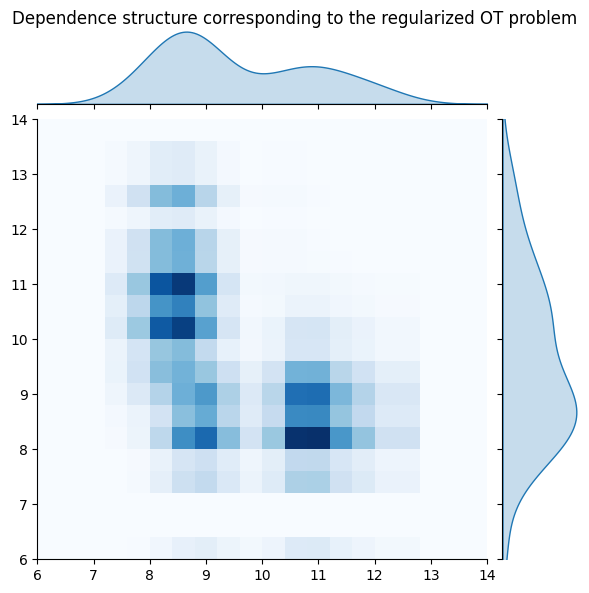

In [15]:
METHOD = 'DUAL'  # 'PRIMAL' or 'DUAL'
# Set cost function, sign to maximize/minimize and cost_1, cost_2 or cost_3 (also: different strikes/shifts or new costs)
C_MAT = -cost_1(np.reshape(xm, [-1, 1]), np.reshape(ym, [1, -1]))
sink_eps = 0.5  # below ~0.05 seems to cause numerical issues
minval = np.min(C_MAT)
C_MAT -= minval
C_MAT /= sink_eps

# The dual version of sinkhorn's algorithm, in log units.
# A multiplicative implementation (without logs) is actually faster,
# but using logsumexp allows for (slightly) lower values of sink_eps
def sinkhorn_dual(cost_mat, marg1, marg2, max_iter=10**4, err_th=10**-9):  # dual step
    # cost_mat should be [n, m], marg1 [n, 1], marg2 [1, m]
    logm1, logm2 = np.log(marg1), np.log(marg2)
    h1, h2 = np.zeros_like(marg1), np.zeros_like(marg2)
    for i in range(max_iter):
        h1p, h2p = h1.copy(), h2.copy()
        h1 = -logsumexp(logm1 + h2 - cost_mat, axis=1, keepdims=1)
        h2 = -logsumexp(logm2 + h1 - cost_mat, axis=0, keepdims=1)
        if np.sum(marg1*np.abs(h1-h1p)) + np.sum(marg2*np.abs(h2-h2p)) < err_th:
            print('iterations: ' + str(i))
            break
    return h1, h2


def sinkhorn_primal(cost_mat, marg1, marg2, theta, max_iter=10**4, err_th=10**-7):
    pi = np.exp(-cost_mat)*theta
    pi /= np.sum(pi)
    for i in range(max_iter):
        pi *= marg1 / np.sum(pi, axis=1, keepdims=1)
        pi *= marg2 / np.sum(pi, axis=0, keepdims=1)
        if np.sum(np.abs(np.sum(pi, axis=0, keepdims=1)-marg2)) + np.sum(np.abs(np.sum(pi, axis=1, keepdims=1)-marg1)) < err_th:
            print('Iterations: ' + str(i))
            break
    return pi


marg1, marg2 = np.ones((n, 1))/n, np.ones((1, n))/n
if METHOD == 'PRIMAL':
    opti = sinkhorn_primal(C_MAT, np.ones(n)/n, np.ones(n)/n, np.outer(marg1, marg2))
else:
    h1, h2 = sinkhorn_dual(C_MAT, np.ones(n)/n, np.ones(n)/n)
    opti = np.exp(-C_MAT+h1+h2)*np.outer(marg1, marg2)
om1, om2 = np.sum(opti, axis=1, keepdims=1), np.sum(opti, axis=0, keepdims=1)
print('Accuracy of the marginals: ', np.sum(np.abs(om1-marg1)), np.sum(np.abs(om2-marg2)))
if np.sum(opti*(C_MAT*sink_eps + minval)) > 0:
  print('Regularized lower bound for possible price range:' + str(np.sum(opti*(C_MAT*sink_eps + minval))))
else:
  print('Regularized upper bound for possible price range:' + str(-np.sum(opti*(C_MAT*sink_eps + minval))))

xypairs = np.meshgrid(xm, ym)
xl = xypairs[0].flatten()
yl = xypairs[1].flatten()
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14], marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.ax_joint.cla()
g.ax_joint.hist2d(xl, yl, weights=opti.reshape(-1, order='F'), bins=int(round(2*np.sqrt(n))), cmap='Blues', range=[[6, 14], [6, 14]])
g.fig.suptitle("Dependence structure corresponding to the regularized OT problem")
g.fig.subplots_adjust(top=0.95)
plt.show()

### Intuition behind regularization and different reference models

We note that the above regularization method implicitly creates a certain bias in our pricing model "towards the independent model". In other words, we start with a certain "reference model" which in this case is the independent one. Then, our robust pricing approach is no longer completely robust, but has two objectives: 1) It wants to be robust, and 2) it wants to stay somewhat close the the reference model. The way to emphasize which of the two objectives should be given more weight is via the regularization parameter epsilon (the larger the regularization parameter, the closer we want to stay to the reference model)

If there is reason to believe in a different reference model, this can be done as well. It is, in a way, equivalent to changing the cost function.

In the following, we introduce a bias towards a smooth random walk structure, i.e., we "want mass around x = y". Note that if epsilon is very large, we basically fully believe in this model (and do not want to be robust any more), while if epsilon is small, the reference model has very little influence and we are almost fully robust (as in the unregularized problem). Again, epsilon is like a dial to be either more robust or more precisely calibrated towards the reference model.

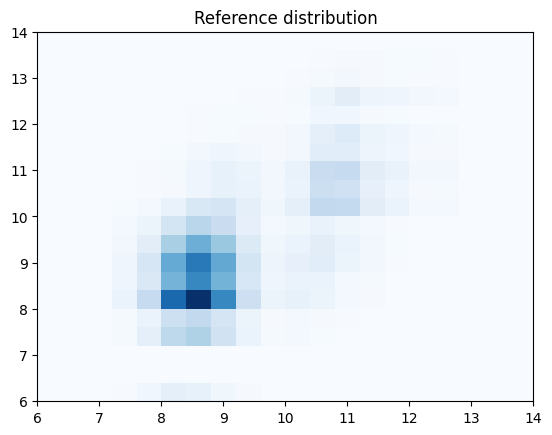

iterations: 70
Accuracy of the marginals:  5.8528737412189e-12 4.40619762898109e-16
Regularized upper bound for possible price range:0.16530241648540359


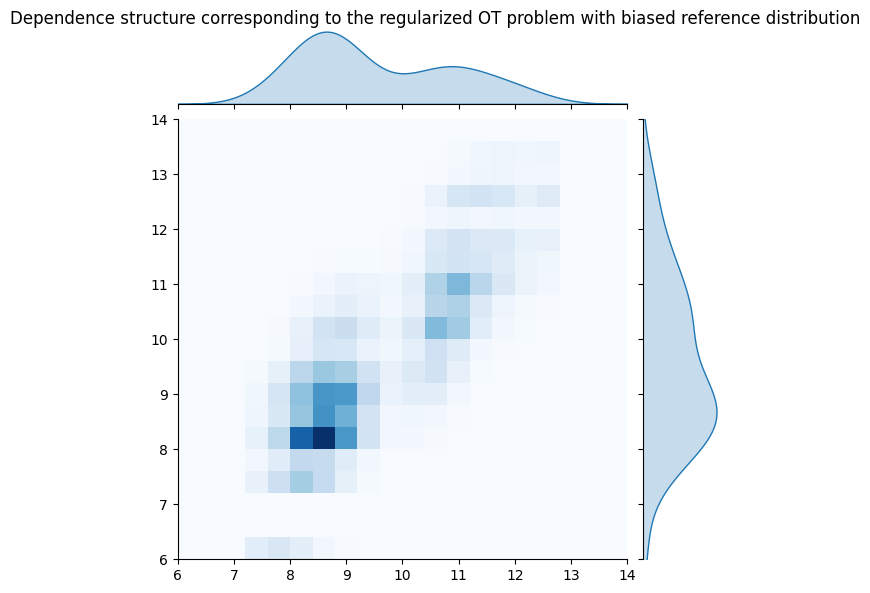

In [16]:
# define log density for our reference distribution with respect to product measure
log_den = 1 * -(np.reshape(xm, [-1, 1]) - np.reshape(ym, [1, -1]))**2
theta = np.outer(marg1, marg2) * np.exp(log_den)
theta /= np.sum(theta)
plt.hist2d(xl, yl, weights=theta.flatten(), bins=int(round(2*np.sqrt(n))), cmap='Blues', range=[[6, 14], [6, 14]])
plt.title('Reference distribution')
plt.show()

# recalculate optimizer with new reference distribution
if METHOD == 'PRIMAL':
    opti = sinkhorn_primal(C_MAT, np.ones(n)/n, np.ones(n)/n, theta)
else:
    C_MAT_hat = C_MAT - log_den  # log density and cost matrix are weighted
    h1, h2 = sinkhorn_dual(C_MAT_hat, np.ones(n)/n, np.ones(n)/n)
    opti = np.exp(-C_MAT_hat+h1+h2)*np.outer(marg1, marg2)
om1, om2 = np.sum(opti, axis=1, keepdims=1), np.sum(opti, axis=0, keepdims=1)
print('Accuracy of the marginals: ', np.sum(np.abs(om1-marg1)), np.sum(np.abs(om2-marg2)))
if np.sum(opti*(C_MAT*sink_eps + minval)) > 0:
  print('Regularized lower bound for possible price range:' + str(np.sum(opti*(C_MAT*sink_eps + minval))))
else:
  print('Regularized upper bound for possible price range:' + str(-np.sum(opti*(C_MAT*sink_eps + minval))))
xypairs = np.meshgrid(xm, ym)
xl = xypairs[0].flatten()
yl = xypairs[1].flatten()
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14], marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.ax_joint.cla()
g.ax_joint.hist2d(xl, yl, weights=opti.reshape(-1, order='F'), bins=int(round(2*np.sqrt(n))), cmap='Blues', range=[[6, 14], [6, 14]])
g.fig.suptitle("Dependence structure corresponding to the regularized OT problem with biased reference distribution")
g.fig.subplots_adjust(top=0.95)
plt.show()


## Martingale Optimal Transport

In any case, regularization introduces a tradeoff between robustness and accuracy. Aside from this tradeoff, one can also include different assumptions or knowledge about the market into the robust pricing objective. The assumption of no arbitrage leads to the MOT problem (see, e.g., the [initial paper by Beiglböck et al](https://link.springer.com/article/10.1007/s00780-013-0205-8) or paper focused on LP methods by [Guo and Obloj](https://www.jstor.org/stable/pdf/26891083.pdf?casa_token=riIuOlkEiF0AAAAA:cU9Z4oWrZ5q_Yzkk0GhcfuLGUMT8jdm29mBO4nFKje2cey78f2DNWdKO-cOs2fTkZ-5LuH_7NZYihDpY7OxmIQSPmtB8Pkj0xuipea2qusuckyeEF-xq)).

The no-arbitrage assumption adds the condition that the pricing models need to be martingales.

LP successful: True
Upper bound for possible price range:0.17278685796607451


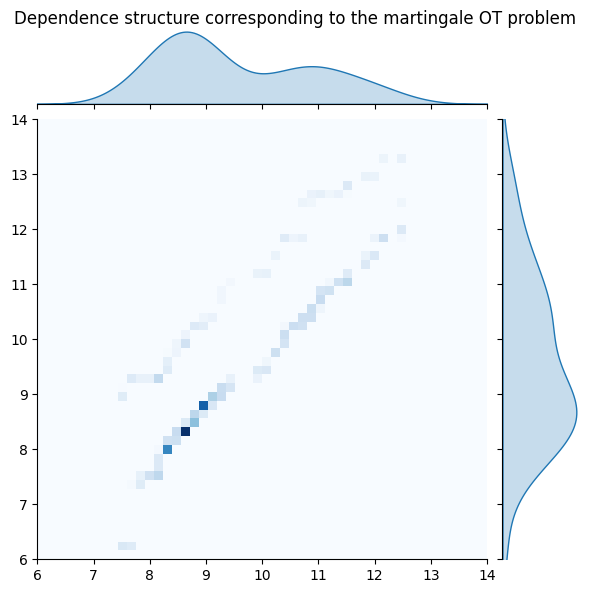

In [17]:
n = 100
np.random.seed(0)
xm, ym = sample_mu(n)

# Set cost function, sign to maximize/minimize and cost_1, cost_2 or cost_3 (also: different strikes/shifts or new costs)
cost_vec = -cost_1(np.reshape(xm, [-1, 1]), np.reshape(ym, [1, -1])).reshape((-1, 1), order='F')


# Use scipy linprog for solving OT, cf. for specifics https://python.quantecon.org/opt_transport.html
mot_eps = 10**-7 # leave a bit of slack for numerical errors for the marginal constraints; see Gaoyou & Jan's paper
A1 = np.kron(np.ones((1, n)), np.identity(n))  # to set first marginal constraint
A2 = np.kron(np.identity(n), np.ones((1, n)))  # to set second marginal constraint
Am = np.kron(np.reshape(ym, (1, n)), np.identity(n))-np.kron(np.ones((1, n)), np.diag(xm))  # for martingale constraint
A = np.vstack([A1, A2])
Aub = np.vstack([Am, -Am])
b = np.ones(2*n)/n  # our marginals are empirical measures, thus all masses are 1/n
bub = np.hstack([np.zeros_like(xm)+mot_eps, np.zeros_like(xm)+mot_eps])
res = linprog(cost_vec, A_eq=A, b_eq=b, A_ub=Aub, b_ub=bub)
print('LP successful: ' + str(res.success))
if np.sum(res.x*cost_vec.flatten()) > 0:
  print('Lower bound for possible price range:' + str(np.sum(res.x*cost_vec.flatten())))
else:
  print('Upper bound for possible price range:' + str(-np.sum(res.x*cost_vec.flatten())))

xypairs = np.meshgrid(xm, ym)
xl = xypairs[0].flatten()
yl = xypairs[1].flatten()
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14], marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.ax_joint.cla()
g.ax_joint.hist2d(xl, yl, weights=res.x, bins=int(round(n/2)), cmap='Blues', range=[[6, 14], [6, 14]])
g.fig.suptitle("Dependence structure corresponding to the martingale OT problem")
g.fig.subplots_adjust(top=0.95)
plt.show()


## Entropically regularized Martingale Optimal Transport

Can we combine (entropic) regularization and additional constraints? While it is not as straightforward as for just the marginal constraints, there are many ways to do so. While some require neural networks (e.g., [Eckstein and Kupper](https://link.springer.com/article/10.1007/s00245-019-09558-1) or [De Gennaro Aquino and Eckstein](https://proceedings.neurips.cc/paper/2020/file/9f067d8d6df2d4b8c64fb4c084d6c208-Paper.pdf)), some are also based on discrete methods similar to Sinkhorn's algorithm (e.g., the paper by [De March](https://arxiv.org/pdf/1812.11104.pdf)). A nice and simple method was recently proposed by [Lindheim and Steidl](https://arxiv.org/pdf/2305.07071.pdf), which is implemented in the following:

Iterations: 4423
Accuracy of the marginals:  1.214306433183765e-16 9.99512916842471e-08
Accuracy of martingale constraint:  1.3452556099414691e-08
Regularized upper bound for possible price range:0.13675876644258525


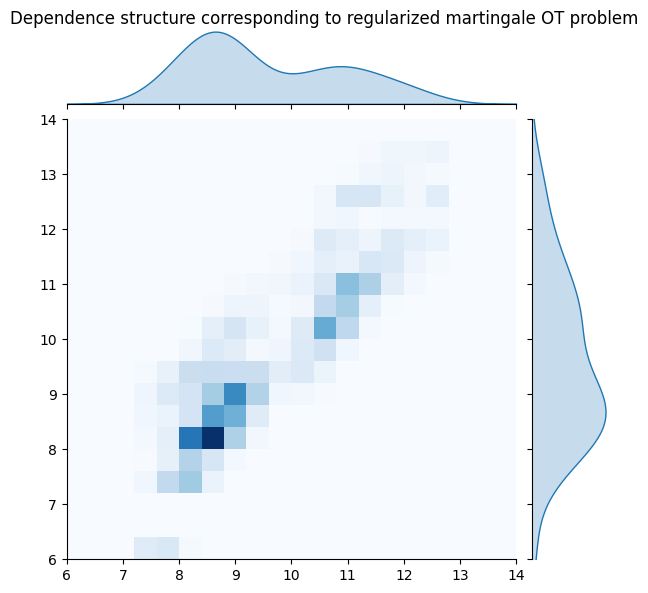

In [19]:
n = 100
np.random.seed(0)
xm, ym = sample_mu(n)
METHOD = 'PRIMAL'  # only 'PRIMAL'
# Set cost function, sign to maximize/minimize and cost_1, cost_2 or cost_3 (also: different strikes/shifts or new costs)
C_MAT = -cost_1(np.reshape(xm, [-1, 1]), np.reshape(ym, [1, -1]))
sink_eps = 0.1
minval = np.min(C_MAT)
C_MAT -= minval
C_MAT /= sink_eps
xi = min(np.min(xm), np.min(ym))
xip = max(np.max(xm-xi), np.max(ym-xi))
Ax = np.vstack([(xm.reshape((1, -1)) - xi) / xip, 1 - (xm.reshape((1, -1)) - xi) / xip])
Ay = np.vstack([(ym.reshape((1, -1)) - xi) / xip, 1 - (ym.reshape((1, -1)) - xi) / xip])

def sinkhorn_primal(cost_mat, marg1, marg2, theta, max_iter=10**4, err_th=10**-7, inner_iter=1):
    pi = np.exp(-cost_mat)*theta
    pi /= np.sum(pi)
    for i in range(max_iter):
        pi *= marg2 / np.sum(pi, axis=0, keepdims=1)
        for iinner in range(inner_iter):
            mh = np.matmul(np.transpose(Ay), np.log(Ax / (np.matmul(Ay, np.transpose(pi)))))
            # the below is simply to enforce that 0log(0/0)=0
            mh[mh == np.inf] = 0
            mh[mh == -np.inf] = 0
            mh = np.nan_to_num(mh, copy=True, nan=0.0)
            pi = np.matmul(np.diag(marg1), pi) * np.transpose(np.exp(mh))
        pi *= marg1 / np.sum(pi, axis=1, keepdims=1)
        if np.sum(np.abs(np.sum(pi, axis=0, keepdims=1)-marg2)) + np.sum(np.abs(np.sum(pi, axis=1, keepdims=1)-marg1)) < err_th:
            if np.mean(np.abs(np.sum(pi * (np.reshape(xm, [-1, 1]) - np.reshape(ym, [1, -1])), axis=1))) < err_th:
                print('Iterations: ' + str(i))
                break
    return pi


marg1, marg2 = np.ones((n, 1))/n, np.ones((1, n))/n
opti = sinkhorn_primal(C_MAT, np.ones(n)/n, np.ones(n)/n, np.outer(marg1, marg2))
om1, om2 = np.sum(opti, axis=1, keepdims=1), np.sum(opti, axis=0, keepdims=1)
print('Accuracy of the marginals: ', np.sum(np.abs(om1-marg1)), np.sum(np.abs(om2-marg2)))
print('Accuracy of martingale constraint: ', np.mean(np.abs(np.sum(opti * (np.reshape(xm, [-1, 1]) - np.reshape(ym, [1, -1])), axis=1))))
if np.sum(opti*(C_MAT*sink_eps + minval)) > 0:
  print('Regularized lower bound for possible price range:' + str(np.sum(opti*(C_MAT*sink_eps + minval))))
else:
  print('Regularized upper bound for possible price range:' + str(-np.sum(opti*(C_MAT*sink_eps + minval))))
xypairs = np.meshgrid(xm, ym)
xl = xypairs[0].flatten()
yl = xypairs[1].flatten()
g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14], marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
g.ax_joint.cla()
g.ax_joint.hist2d(xl, yl, weights=opti.reshape(-1, order='F'), bins=int(round(2*np.sqrt(n))), cmap='Blues', range=[[6, 14], [6, 14]])
g.fig.suptitle("Dependence structure corresponding to regularized martingale OT problem")
g.fig.subplots_adjust(top=0.95)
plt.show()

ADD_REFERENCE_DIST = 0
if ADD_REFERENCE_DIST:
  # again, can use a different reference distribution
  log_den = 1 * -(np.reshape(xm, [-1, 1]) - np.reshape(ym, [1, -1]))**2
  theta = np.outer(marg1, marg2) * np.exp(log_den)
  theta /= np.sum(theta)
  plt.hist2d(xl, yl, weights=theta.flatten(), bins=int(round(2*np.sqrt(n))), cmap='Blues', range=[[6, 14], [6, 14]])
  plt.show()
  opti = sinkhorn_primal(C_MAT, np.ones(n)/n, np.ones(n)/n, theta)
  om1, om2 = np.sum(opti, axis=1, keepdims=1), np.sum(opti, axis=0, keepdims=1)
  print('Accuracy of the marginals: ', np.sum(np.abs(om1-marg1)), np.sum(np.abs(om2-marg2)))
  print('Accuracy of martingale constraint: ', np.mean(np.abs(np.sum(opti * (np.reshape(xm, [-1, 1]) - np.reshape(ym, [1, -1])), axis=1))))
  if np.sum(opti*(C_MAT*sink_eps + minval)) > 0:
    print('Regularized lower bound for possible price range:' + str(np.sum(opti*(C_MAT*sink_eps + minval))))
  else:
    print('Regularized upper bound for possible price range:' + str(-np.sum(opti*(C_MAT*sink_eps + minval))))
  xypairs = np.meshgrid(xm, ym)
  xl = xypairs[0].flatten()
  yl = xypairs[1].flatten()
  g = sns.jointplot(x=xm, y=ym, kind="kde", xlim=[6, 14], ylim=[6, 14], marginal_kws=dict(fill=True), joint_kws=dict(fill=True, alpha=1))
  g.ax_joint.cla()
  g.ax_joint.hist2d(xl, yl, weights=opti.reshape(-1, order='F'), bins=int(round(2*np.sqrt(n))), cmap='Blues', range=[[6, 14], [6, 14]])
  g.fig.suptitle("Dependence structure corresponding to regularized martingale OT problem with reference distribution")
  g.fig.subplots_adjust(top=0.95)
  plt.show()


## Disclaimer and further references

Note that all references above and below are highly biased towards papers which I am familiar with in this context. There is certainly a much wider spectrum of works going in the direction of robust pricing and model uncertainty.

Some further references which go beyond what was shown in this simple example: E.g., joint calibration of stock and volatility [Guyon](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3397382), time homogeneity for multiperiod models [Eckstein and Kupper](https://www.tandfonline.com/doi/full/10.1080/14697688.2020.1787493?casa_token=_6KFkIC_Be8AAAAA%3A5zZ4SxpEqYOBeRubH5wpUQd5QFV3IPVQB1KbW10DFVQTdJEBLJ7UAgLbGTxeWA5MC8G-kCV1us2O3AA), volatility information [Sester and Lütkebohmert](https://www.tandfonline.com/doi/abs/10.1080/14697688.2019.1603394?role=tab&scroll=top&needAccess=true&journalCode=rquf20), Markovianity property [Sester](https://www.worldscientific.com/doi/abs/10.1142/S0219024920500156?casa_token=nRpFDYd28P4AAAAA:cJdHiFqe5BfVADw0tubpyAm6HDHSn7-_7WJm2iMw_oMT8hqSpcnVeHH0bqaQti8iszmLZxpSqyHE), multiasset settings [Eckstein et al](https://epubs.siam.org/doi/abs/10.1137/19M1286256?casa_token=-xSlwIEMdRwAAAAA:5-CgNLh0sa2SO81qCFqOe6SZE3M1EwkPjtQoM54Rh7PHc90WNHSIGVql4qUks3jO09996-7AuYCr), etc...